<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week6/GRU_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GRU Model dengan TensorFlow: DeteksiSarkasme.json👩‍🚀**

##Import Library

In [27]:
import keras_tuner as kt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import json

#Load Dataset

In [2]:
# Load your dataset
import json
with open("/content/Cleaned_DeteksiSarkasme.json") as f:
    data = json.load(f)

In [28]:
# Extracting the text and labels
texts = [item['headline'] for item in data]
labels = [item['is_sarcastic'] for item in data]

In [29]:

# Tokenizing the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)
X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, padding='post')

In [30]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)


#Build Model

In [31]:
# Define the model-building function
def build_model(hp):
    model = Sequential()

    # Hyperparameter tuning for embedding dimension
    model.add(Embedding(input_dim=5000,
                        output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=32),
                        input_length=X.shape[1]))

    # Hyperparameter tuning for GRU units
    model.add(GRU(hp.Int('gru_units', min_value=32, max_value=128, step=32)))

    # Dropout layer to prevent overfitting
    model.add(Dropout(0.5))

    # Dense layer
    model.add(Dense(32, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [32]:
# Initialize Keras Tuner with Hyperband as the search algorithm
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',  # Aim to maximize validation accuracy
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='sarcasm_detection')


Reloading Tuner from my_dir/sarcasm_detection/tuner0.json


In [34]:
import numpy as np

# Ensure that X_train and y_train are NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


#Hyperparameter Tuning

In [35]:
# Start the hyperparameter search
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Trial 20 Complete [00h 00m 26s]
val_accuracy: 0.8562335968017578

Best val_accuracy So Far: 0.8597903251647949
Total elapsed time: 00h 10m 25s


In [36]:
# Retrieve the best model after the search
best_model = tuner.get_best_models(num_models=1)[0]


## Train Model

In [37]:
# Train the best model
history = best_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9097 - loss: 0.2312 - val_accuracy: 0.8472 - val_loss: 0.3516
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9349 - loss: 0.1751 - val_accuracy: 0.8557 - val_loss: 0.3819
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9557 - loss: 0.1237 - val_accuracy: 0.8476 - val_loss: 0.4532
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9738 - loss: 0.0778 - val_accuracy: 0.8433 - val_loss: 0.6029
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9778 - loss: 0.0584 - val_accuracy: 0.8426 - val_loss: 0.7902


## Visualisasi

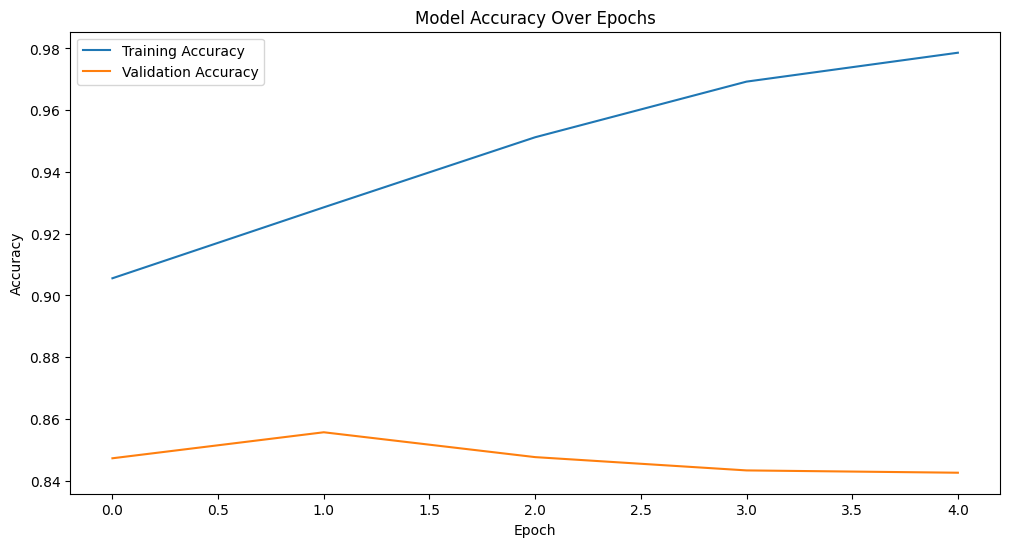

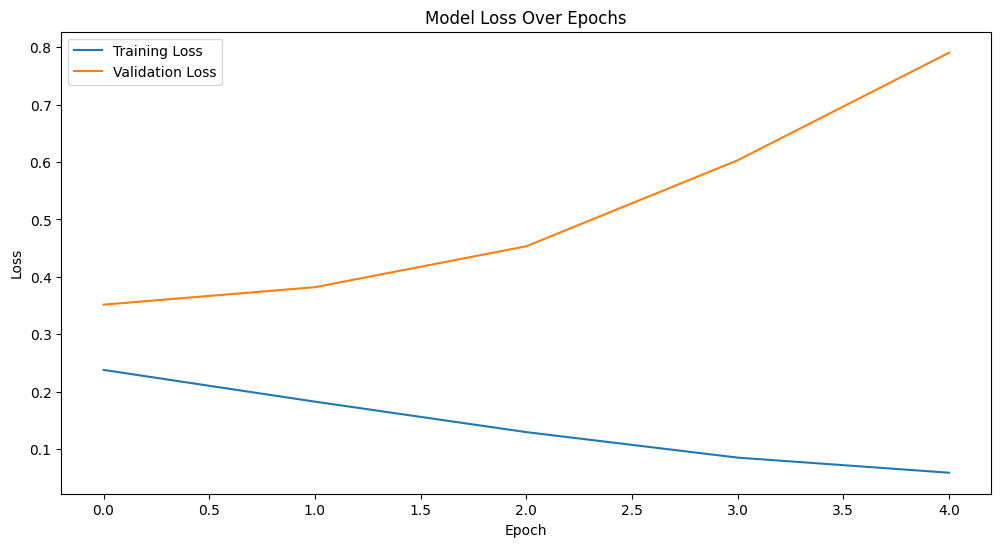

In [39]:
import matplotlib.pyplot as plt

# Visualisasi akurasi pelatihan dan validasi
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()

# Visualisasi loss pelatihan dan validasi
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()


#Matrik Evaluasi

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2996
           1       0.83      0.81      0.82      2346

    accuracy                           0.84      5342
   macro avg       0.84      0.84      0.84      5342
weighted avg       0.84      0.84      0.84      5342



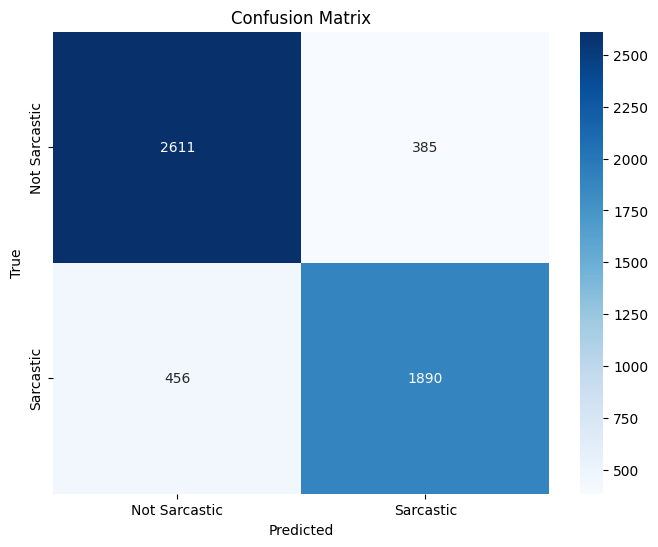

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
AUC: 0.9121


In [40]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import numpy as np

# Predict values using the best model
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# Classification report (Precision, Recall, F1-Score)
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# AUC (Area Under the Curve)
y_pred_prob = best_model.predict(X_test)  # Get probability scores
auc = roc_auc_score(y_test, y_pred_prob)
print(f'AUC: {auc:.4f}')
